In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [46]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import shap
import matplotlib.pyplot as plt
import missingno as msn
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')


from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from tpot import TPOTClassifier

In [47]:
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test= pd.read_csv('../input/spaceship-titanic/test.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


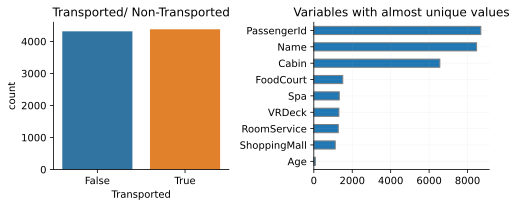

In [48]:
fig, axes = plt.subplots(ncols=2, figsize=(7,3))
sns.countplot(train['Transported'], ax=axes[0])
axes[0].set_title('Transported/ Non-Transported')
train_uniqs = train.nunique().sort_values()
train_uniqs[train_uniqs>4].plot.barh(edgecolor='gray', ax=axes[1])
axes[1].grid(alpha=.1)
axes[1].set_title('Variables with almost unique values')
for spine in ['right','top']:
    axes[1].spines[spine].set_visible(False)
sns.despine()
plt.tight_layout()
train['Group'] = train.PassengerId.apply(lambda x: x[:4])
train = train.drop(['Name','PassengerId'], axis=1)

In [49]:
test= pd.read_csv('../input/spaceship-titanic/test.csv')

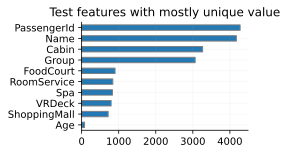

KeyError: 'Cabin'

In [50]:
test_id = test['PassengerId']
test['Group'] = test.PassengerId.apply(lambda x: x[:4])

fig = plt.figure(figsize=(3,2
                         ))
ax = plt.axes()
train_uniqs = test.nunique().sort_values()
train_uniqs[train_uniqs>4].plot.barh(edgecolor='gray', ax=ax)
ax.grid(alpha=.1)

for spine in ['right','top']:
    ax.spines[spine].set_visible(False)

ax.set_title('Test features with mostly unique value')

plt.show()

test['Cabin_f'] = test.Cabin.apply(lambda x: str(x)[:1])
test['Cabin_n'] = test.Cabin.apply(lambda x: str(x)[2])
test['Cabin_b'] = test.Cabin.apply(lambda x: str(x)[-1:])
X_test.pop('Cabin')
test = test.drop(['Name','PassengerId'], axis=1)

In [ ]:
y_train = train.pop('Transported')
y_train = y_train.apply(lambda x: 1 if x is True else 0)

le = LabelEncoder()
scl = StandardScaler()
#mxs = MinMaxScaler()

cols = train.select_dtypes('object').columns
comb = train[cols].append(test[cols])

for col in comb.columns:
    comb[col] = le.fit(comb[col])
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    
train = train.fillna(train.median())
test = test.fillna(test.median())
test.pop('Cabin') 
X_train = train
X_test = test

X_train[X_train.columns] = scl.fit_transform(X_train)

X_test[X_test.columns] = scl.transform(X_test)


In [ ]:
 
def metrics(estimators, X_train, y_train):
    metrics = []
    for name, model in estimators.items():
        fig, axes = plt.subplots(ncols=3, figsize=(12,4))
        y_pred = mod.predict(X_train)
        mod = model.fit(X_train, y_train)
        plot_precision_recall_curve(mod, X_train, y_train, ax=axes[0], color='black')
        plot_roc_curve(mod, X_train, y_train, drop_intermediate=True, ax = axes[1], color='black')
        axes[1].plot([1,0],[1,0], c='green',ls='--', lw=.9)
        axes[1].set_title(f'ROC Curve for {name}')
        axes[0].set_title(f'Precision-Recall Curve for {name}')
        confusion_plot(name,y_train, y_pred, axes[2])
        for spine in ['top','right']:
            for axe in axes:
                axe.spines[spine].set_visible(False)
                axe.legend(loc='lower center', frameon=False, fontsize=10)
        for axe in axes.ravel():
            axe.legend(frameon=False)
        scores = {}
        scores['accuracy_score'] = accuracy_score(y_train, y_pred)
        scores['classifier'] = name
        scores['f1_score'] = f1_score(y_train,y_pred)
        scores['roc_auc_score']=roc_auc_score(y_train, y_pred)
        plt.tight_layout()
        metrics.append(scores)
    return show_metrics(metrics)

In [ ]:
light_gradient_boosting = LGBMClassifier(random_state=42)
estimators = {'LGBM':light_gradient_boosting}
metrics(estimators, X_train, y_train)

In [ ]:
y_pred = light_gradient_boosting.predict(X_test)
y_pred = y_pred.astype('bool')
submission = pd.DataFrame({'PassengerId':test_id,'Transported': y_pred})
submission.to_csv('submission.csv', index=False)